# Project Phase II

### Research Question(s)

A person's life expentancy in a given country can be predicted by different metrics of their country, including violent crime rates, health care, diet, economic development, genetics, and happiness level.

# Data Collection and Cleaning

- Ryan: life expectancies, violent crime
- John: health care, diet, economic develpment
- Chase: genetics, happiness level

1. Find all data
- Each person does their assigned data set
2. Clean data sets
- Each person does their assigned data set
3. Group data sets (if needed)
- Each person does their assigned data set
4. Join data sets
- Chase

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:
            
import regex as re
import requests
from bs4 import BeautifulSoup

/Users/jn/opt/anaconda3/lib/python3.9/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### Life Expectancy
#### https://data.worldbank.org/indicator/SP.DYN.CDRT.IN
I found and used this dataset after discovering that the original data we wanted to use from the UN only allowed 100k rows to be downloaded. I downloaded this data and filtered down to the two columns we were looking for, country name, and the most recent year of data. I then renamed these columns to be simplified to "Country" and "Life Expectancy".

In [2]:
df_life_expectancies = pd.read_csv("data/life-expectancies.csv")
df_life_expectancies = df_life_expectancies[["Country Name","2020"]].rename(columns={"Country Name" : "Country","2020" : "Life Expectancy"})
df_life_expectancies.head(5)

,Country,Life Expectancy
0,Aruba,76.434000
1,Africa Eastern and Southern,64.325702
2,Afghanistan,65.173000
3,Africa Western and Central,58.445953
4,Angola,61.487000


## Intentional Homicide Rate
#### https://worldpopulationreview.com/country-rankings/murder-rate-by-country
I have found and used the violent crime dataset from the world population review. I then downloaded it and read it into a pandas data frame. I narrowed it down to our columns of interest and renamed them. This dataset still had null values in it, which made a regression impossible, so I removed these with a boolean index.

In [3]:
df_crime = pd.read_csv("data/violent-crime-rates.csv")
df_crime = df_crime[["country","homRate"]].rename(columns={"country":"Country","homRate":"Homicide Rate"})
df_crime = df_crime.loc[df_crime["Homicide Rate"].notnull()]

In [10]:
df_ryan_final = df_life_expectancies.merge(df_crime,on='Country')
df_ryan_final

,Country,Life Expectancy,Homicide Rate
0,Aruba,76.434,1.93
1,Afghanistan,65.173,6.66
2,Angola,61.487,4.85
3,Albania,78.686,2.29
4,Andorra,NaN,0.00
...,...,...,...
160,Vietnam,75.493,1.53
161,Samoa,73.450,3.15
162,South Africa,64.379,36.40
163,Zambia,64.194,5.37


## Economic Development
#### https://hdr.undp.org/data-center/human-development-index#/indicies/HDI
From the site: "The Human Development Index (HDI) is a summary measure of average achievement in key dimensions of human development: a long and healthy life, being knowledgeable and have a decent standard of living. The HDI is the geometric mean of normalized indices for each of the three dimensions."

Included later on is GNI per capita, the average income of an individual for the country, and is Purchasing Power Parity(PPP)-adjusted, and life expectancy.

In [11]:
evens_only = np.arange(2,32,2)
add_unnamed = lambda x : "Unnamed: "+ str(x)
evens_only = list(map(add_unnamed, evens_only))
evens_only.remove("Unnamed: 24")
evens_only.append("SDG10.1")
hdi_df = pd.read_excel("data/HDR21-22_Statistical_Annex_I-HDI_Table.xlsx", 
#                       )
                       usecols=["Table 3. Inequality-adjusted Human Development Index "]+evens_only)

#clean up column names
hdi_df = hdi_df[1:]
headers = hdi_df.iloc[0]
header_types = hdi_df.iloc[1]
for i, header in enumerate(headers):
    header = str(header) + ", " if str(header) != "nan" else ""
    header_types[i] = str(header_types[i]) if header_types[i] != "nan" else ""
    headers[i] = f'{header}{header_types[i]}'
    
hdi_df = hdi_df[3:].rename(columns=headers)
hdi_df = hdi_df.rename(columns={hdi_df.columns[0]:"Country"})
hdi_df = hdi_df[hdi_df["Country"].notnull()]

#partition with respect to levels of human development 
levels = hdi_df[hdi_df["Country"].str.contains("human development", na=False)]
# print(levels['Country'].index)
#4: v high, 71: high, 121: med, 166: low
#206-209: aggregates; 210-226: regions avgs (but no country:region mapping, so it's kinda useless) 
hdi_df["Level of human development"] = "Very high"
hdi_df.loc[71:121,"Level of human development"] = "High"
hdi_df.loc[121:166,"Level of human development"] = "Medium"
hdi_df.loc[166:204,"Level of human development"] = "Low"
hdi_df.loc[200:,"Level of human development"] = "n/a"

hdi_df = hdi_df[:200] #note: cutting off region data
hdi_df.iloc[-10:]
hdi_df = hdi_df.dropna(axis=0) #drop the "human development" header rows (rows with NaN's)
hdi_df[:-50]

#replace periods with -99.9 to allow for sorting
hdi_df = hdi_df.replace(to_replace=r'^\.+', value=-99.9, regex=True) 

# hdi_df = hdi_df.sort_values(by="Overall loss (%)", ascending=False)
# hdi_df[hdi_df["Country"] == "United States"]
hdi_df = hdi_df.reset_index(drop=True)
hdi_df.head()
#convert all strings to 0

# hdi_df[207:]
# hdi_df.shape
# hdi_df[239:]
# hdi_df[206:] #regions are from 210 to 226 

,Country,"Human Development Index (HDI), Value","Inequality-adjusted HDI (IHDI), Value",Overall loss (%),Difference from HDI rank,"Coefficient of human inequality, nan","Inequality in life expectancy, (%)","Inequality-adjusted life expectancy index, Value","Inequality in education, (%)","Inequality-adjusted education index, Value","Inequality in income, (%)","Inequality-adjusted income index, Value","Income shares held by (%), Poorest 40 percent",Richest 10 percent,Richest 1 percent,Gini coefficient,Level of human development
0,Switzerland,0.962,0.894,7.068607,-3,6.899906,3.103429,0.953868,2.01457,0.90179,15.58172,0.829672,19.9,25.8,11.46,33.1,Very high
1,Norway,0.961,0.908,5.515088,0,5.435152,2.541615,0.948104,2.3324,0.911682,11.43144,0.865839,22.9,22.4,8.88,27.7,Very high
2,Iceland,0.959,0.915,4.588113,2,4.556437,1.954472,0.945433,2.20077,0.937802,9.51407,0.864396,23.9,22.1,8.78,26.1,Very high
3,"Hong Kong, China (SAR)",0.952,0.828,13.02521,-19,12.429978,2.055595,0.979444,9.671619,0.801655,25.56272,0.724064,-99.9,-99.9,17.85,-99.9,Very high
4,Australia,0.951,0.876,7.886435,-6,7.640183,2.73798,0.965535,3.05657,0.895978,17.126,0.77606,19.5,26.6,11.28,34.3,Very high


#### Life Expectancies and other indicators
- UN dataset again, this time having columns like life expectancy and GNI per capita

In [12]:
#life expectancies and whatnot
evens_only = np.arange(2,16,2)
add_unnamed = lambda x : "Unnamed: "+ str(x)
evens_only = list(map(add_unnamed, evens_only))
evens_only += ["Table 1. Human Development Index and its components "]
life_df = pd.read_excel("data/HDR21-22_Statistical_Annex_HDI_Table.xlsx", usecols=evens_only)
life_df[:10]
col_names = life_df.iloc[3]
life_df = life_df[1:].rename(columns=col_names)
life_df = life_df.dropna(axis=0) #drop NaN rows -- the "high development countries" header thing gets dropped too
life_df = life_df.rename(columns={life_df.columns[0]: "Country", "Human Development Index (HDI) ": "Human Development Index (HDI)"})
# life_df.sort_values(by=['Country']).head()
life_df = life_df.reset_index(drop=True)
life_df = life_df[:195]
life_df = life_df.replace(to_replace=r'^\.+', value=-99.9, regex=True)
life_df.head()

,Country,Human Development Index (HDI),Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank,HDI rank
0,Switzerland,0.962,83.9872,16.500299,13.85966,66933.00454,5,3
1,Norway,0.961,83.2339,18.1852,13.00363,64660.10622,6,1
2,Iceland,0.959,82.6782,19.163059,13.76717,55782.04981,11,2
3,"Hong Kong, China (SAR)",0.952,85.4734,17.27817,12.22621,62606.8454,6,4
4,Australia,0.951,84.5265,21.05459,12.72682,49238.43335,18,5


In [13]:
#Join the two datasets on country name 
print(f"should be same # rows b/c they're from the same site: \nhdi_df: {hdi_df.shape}, life_df: {life_df.shape}")
full_hdi_df = hdi_df.join(life_df.set_index('Country'), on="Country")
print(f'full_hdi_df:{full_hdi_df.shape}')
full_hdi_df = full_hdi_df.drop(columns="Human Development Index (HDI)") #drop extra HDI col
full_hdi_df.columns

#remove "Value" and commas from column names
cols_edit = list(map(lambda x: x.replace(", Value", ""), full_hdi_df.columns))
cols_edit = list(map(lambda x: x.replace(",", ""), cols_edit))
col_dict = {}
for i, col in enumerate(full_hdi_df):
    col_dict[col] = cols_edit[i]
full_hdi_df = full_hdi_df.rename(columns=col_dict)
full_hdi_df = full_hdi_df.sort_values(by="Country")
full_hdi_df.head()
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(full_hdi_df)

# full_hdi_df.columns

should be same # rows b/c they're from the same site: 
hdi_df: (195, 17), life_df: (195, 8)
full_hdi_df:(195, 24)


,Country,Human Development Index (HDI),Inequality-adjusted HDI (IHDI),Overall loss (%),Difference from HDI rank,Coefficient of human inequality nan,Inequality in life expectancy (%),Inequality-adjusted life expectancy index,Inequality in education (%),Inequality-adjusted education index,...,Richest 10 percent,Richest 1 percent,Gini coefficient,Level of human development,Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank,HDI rank
179,Afghanistan,0.478,-99.9,-99.9,-99.9,-99.9,26.165367,0.476885,45.36517,0.210131,...,-99.9,15.25,-99.9,Low,61.9824,10.263844,2.98507,1824.190915,-2,177
66,Albania,0.796,0.71,10.80402,5,10.767685,6.790635,0.809668,12.33344,0.68165,...,23.8,8.91,30.8,High,76.4626,14.448,11.286455,14131.11039,17,68
90,Algeria,0.745,0.598,19.731544,-7,19.072875,12.430804,0.759517,33.28262,0.450528,...,22.9,9.91,27.6,High,76.3767,14.626896,8.069284,10800.22546,13,96
39,Andorra,0.858,-99.9,-99.9,-99.9,-99.9,5.29791,0.879541,10.008154,0.649101,...,-99.9,-99.9,-99.9,Very high,80.3684,13.300239,10.55512,51166.62661,-19,45
147,Angola,0.586,0.407,30.546075,-2,30.412168,28.187733,0.460078,34.17144,0.341449,...,39.6,25.98,51.3,Medium,61.6434,12.1721,5.417391,5465.617791,-14,149


In [14]:
#correct the country names w.r.t. Wikipedia
changes_dict = {
    "Bolivia (Plurinational State of)": "Bolivia",
    "Congo (Democratic Republic of the)" : "Democratic Republic of the Congo",
    "Congo" : "Republic of the Congo",
    "Hong Kong, China (SAR)" : "Hong Kong",
    "Iran (Islamic Republic of)" : "Iran",
    "Korea (Democratic People's Rep. of)" : "North Korea",
    "Korea (Republic of)" : "South Korea",
    "Lao People's Democratic Republic" : "Laos",
    "Moldova (Republic of)" : "Moldova",
    "Russian Federation" : "Russia",
    "Syrian Arab Republic" : "Syria",
    "Tanzania (United Republic of)" : "Tanzania",
    "Venezuela (Bolivarian Republic of)" : "Venezuela",
    "Viet Nam" : "Vietnam",
    "United States" : "United States of America",
    "Türkiye": "Turkey",
    "Gambia": "The Gambia",
    "Eswatini (Kingdom of)": "Eswatini",
    "Czechia" : "Czech Republic",
    "Brunei Darussalam": "Brunei"
}
for old, new in changes_dict.items():
    full_hdi_df.loc[full_hdi_df['Country'] == old, "Country"] = new

full_hdi_df = full_hdi_df.sort_values(by="Country")
full_hdi_df.head()
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(full_hdi_df)

,Country,Human Development Index (HDI),Inequality-adjusted HDI (IHDI),Overall loss (%),Difference from HDI rank,Coefficient of human inequality nan,Inequality in life expectancy (%),Inequality-adjusted life expectancy index,Inequality in education (%),Inequality-adjusted education index,...,Richest 10 percent,Richest 1 percent,Gini coefficient,Level of human development,Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank,HDI rank
179,Afghanistan,0.478,-99.9,-99.9,-99.9,-99.9,26.165367,0.476885,45.36517,0.210131,...,-99.9,15.25,-99.9,Low,61.9824,10.263844,2.98507,1824.190915,-2,177
66,Albania,0.796,0.71,10.80402,5,10.767685,6.790635,0.809668,12.33344,0.68165,...,23.8,8.91,30.8,High,76.4626,14.448,11.286455,14131.11039,17,68
90,Algeria,0.745,0.598,19.731544,-7,19.072875,12.430804,0.759517,33.28262,0.450528,...,22.9,9.91,27.6,High,76.3767,14.626896,8.069284,10800.22546,13,96
39,Andorra,0.858,-99.9,-99.9,-99.9,-99.9,5.29791,0.879541,10.008154,0.649101,...,-99.9,-99.9,-99.9,Very high,80.3684,13.300239,10.55512,51166.62661,-19,45
147,Angola,0.586,0.407,30.546075,-2,30.412168,28.187733,0.460078,34.17144,0.341449,...,39.6,25.98,51.3,Medium,61.6434,12.1721,5.417391,5465.617791,-14,149


## Diet 
- meat consumption: https://en.wikipedia.org/wiki/List_of_countries_by_meat_consumption
    - try to get most recent, non-2019 (pandemic year) data
    - set to -99.9 otherwise
- caloric intake: https://en.wikipedia.org/wiki/List_of_countries_by_food_energy_intake
    - set to -99.9 if the country has no data
    
- `kg meat/person`: yearly consumption of meat per person in kg
- `cal`: daily caloric intake

In [15]:
#meat consumption by country (2017 or earlier)
meat_url = 'https://en.wikipedia.org/wiki/List_of_countries_by_meat_consumption'
meat_rq = requests.get(meat_url)
if meat_rq.status_code != 200:
  print("something went wrong:", meat_rq.status_code, meat_rq.reason)

with open("data/meat_rq.html", "w",encoding='utf-7') as writer: 
  writer.write(meat_rq.text)

with open("data/meat_rq.html", "r") as reader:
  meat_source = reader.read()

meat_soup = BeautifulSoup(meat_source, "html.parser")
table = meat_soup.find("table", {"class": "wikitable"})
meat_dict = {"Country": [], "kg meat/person":[]}
for row in table.findAll("tr")[1:]: 
    meat_dict['Country'].append(row.find("a").text)
    
    #try to find most recent year with data, and set to -99.9 otherwise
    vals = row.findAll("td")
    val_final = -99.9
    for val in vals[-2::-1]: #iterate backwards for most recent; skip 2019 b/c of pandemic
        try:
            val_final = float(val.text)
        except:
            continue 
        break
    meat_dict['kg meat/person'].append(val_final)
    
meat_df = pd.DataFrame.from_dict(data=meat_dict)
# print(meat_df.shape)

#fix some names
meat_df.loc[meat_df["Country"] == "Cape Verde", "Country"] = "Cabo Verde"
meat_df.loc[meat_df["Country"] == "American Samoa", "Country"] = "Samoa"
meat_df.loc[meat_df["Country"] == "Swaziland", "Country"] = "Eswatini"

#join with HDI and drop the NaN's
full_df = full_hdi_df.join(meat_df.set_index('Country'), on="Country")
full_df = full_df.fillna(-99.9)

#print countries that were left out 
un_countries = list(full_df['Country'])
not_in = ""
for country in meat_df["Country"]:
    if country not in un_countries:
        not_in += f"{country}, "
    else: pass
print(f"Countries in meat_df but not UN's dataset: {not_in}")

full_df.head()
#display to check
# full_df = full_df.sort_values(by="Country")
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(full_df)

Countries in meat_df but not UN's dataset: C+APQ-te d'Ivoire, French Guiana, French Polynesia, Guadeloupe, Macao, Netherlands Antilles, New Caledonia, Reunion, FR Yugoslavia, Taiwan, 


,Country,Human Development Index (HDI),Inequality-adjusted HDI (IHDI),Overall loss (%),Difference from HDI rank,Coefficient of human inequality nan,Inequality in life expectancy (%),Inequality-adjusted life expectancy index,Inequality in education (%),Inequality-adjusted education index,...,Richest 1 percent,Gini coefficient,Level of human development,Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank,HDI rank,kg meat/person
179,Afghanistan,0.478,-99.900,-99.900000,-99.9,-99.900000,26.165367,0.476885,45.365170,0.210131,...,15.25,-99.9,Low,61.9824,10.263844,2.985070,1824.190915,-2.0,177.0,-99.90
66,Albania,0.796,0.710,10.804020,5.0,10.767685,6.790635,0.809668,12.333440,0.681650,...,8.91,30.8,High,76.4626,14.448000,11.286455,14131.110390,17.0,68.0,47.51
90,Algeria,0.745,0.598,19.731544,-7.0,19.072875,12.430804,0.759517,33.282620,0.450528,...,9.91,27.6,High,76.3767,14.626896,8.069284,10800.225460,13.0,96.0,18.06
39,Andorra,0.858,-99.900,-99.900000,-99.9,-99.900000,5.297910,0.879541,10.008154,0.649101,...,-99.90,-99.9,Very high,80.3684,13.300239,10.555120,51166.626610,-19.0,45.0,-99.90
147,Angola,0.586,0.407,30.546075,-2.0,30.412168,28.187733,0.460078,34.171440,0.341449,...,25.98,51.3,Medium,61.6434,12.172100,5.417391,5465.617791,-14.0,149.0,23.49


In [16]:
#caloric intake by country (2018)
cal_url = 'https://en.wikipedia.org/wiki/List_of_countries_by_food_energy_intake'
cal_rq = requests.get(cal_url)
if cal_rq.status_code != 200:
  print("something went wrong:", cal_rq.status_code, cal_rq.reason)

with open("data/cal_rq.html", "w", encoding='utf-7') as writer: 
  writer.write(cal_rq.text)

with open("data/cal_rq.html", "r") as reader:
  cal_source = reader.read()

cal_soup = BeautifulSoup(cal_source, "html.parser")
table = cal_soup.find("table", {"class": "wikitable"})
cal_dict = {"Country": [], "cal":[]}
for row in table.findAll("tr")[2:]: #skip the two headers and check each row
    cal_dict['Country'].append(row.find("a").text)
    
    #rstrip() to remove the newline characters, and remove commas
    cal_dict['cal'].append(float(row.findAll("td")[2].text.rstrip().replace(",","")))
    
cal_df = pd.DataFrame.from_dict(data=cal_dict)

#fix some names
cal_df.loc[cal_df["Country"] == "United States", "Country"] = "United States of America"
cal_df.loc[cal_df["Country"] == "Gambia", "Country"] = "The Gambia"
cal_df.loc[cal_df["Country"] == "São Tomé and Príncipe", "Country"] = "Sao Tome and Principe"
cal_df.loc[cal_df["Country"] == "Ivory Coast", "Country"] = "Côte d'Ivoire"
cal_df.loc[cal_df["Country"] == "Cape Verde", "Country"] = "Cabo Verde"

#join with everything else 
full_df1 = full_df.join(cal_df.set_index('Country'), on="Country")
full_df1 = full_df1.fillna(-99.9)

#print countries that were left out 
un_countries = list(full_df1['Country'])
not_in = ""
for country in cal_df["Country"]:
    if country not in un_countries:
        not_in += f"{country}, "
    else: pass
print(f"Countries in cal_df but not UN's dataset: {not_in}")
    

#display to check
full_df1.head()
# full_df1 = full_df1.sort_values(by="Country")
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(full_df1)

Countries in cal_df but not UN's dataset: Taiwan, New Caledonia, S+AOM-o Tom+AOk and Pr+AO0-ncipe, 


,Country,Human Development Index (HDI),Inequality-adjusted HDI (IHDI),Overall loss (%),Difference from HDI rank,Coefficient of human inequality nan,Inequality in life expectancy (%),Inequality-adjusted life expectancy index,Inequality in education (%),Inequality-adjusted education index,...,Gini coefficient,Level of human development,Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank,HDI rank,kg meat/person,cal
179,Afghanistan,0.478,-99.900,-99.900000,-99.9,-99.900000,26.165367,0.476885,45.365170,0.210131,...,-99.9,Low,61.9824,10.263844,2.985070,1824.190915,-2.0,177.0,-99.90,2040.0
66,Albania,0.796,0.710,10.804020,5.0,10.767685,6.790635,0.809668,12.333440,0.681650,...,30.8,High,76.4626,14.448000,11.286455,14131.110390,17.0,68.0,47.51,3360.0
90,Algeria,0.745,0.598,19.731544,-7.0,19.072875,12.430804,0.759517,33.282620,0.450528,...,27.6,High,76.3767,14.626896,8.069284,10800.225460,13.0,96.0,18.06,3322.0
39,Andorra,0.858,-99.900,-99.900000,-99.9,-99.900000,5.297910,0.879541,10.008154,0.649101,...,-99.9,Very high,80.3684,13.300239,10.555120,51166.626610,-19.0,45.0,-99.90,-99.9
147,Angola,0.586,0.407,30.546075,-2.0,30.412168,28.187733,0.460078,34.171440,0.341449,...,51.3,Medium,61.6434,12.172100,5.417391,5465.617791,-14.0,149.0,23.49,2385.0


## Healthcare
- has/does not have universal health care (UHC): https://en.wikipedia.org/wiki/List_of_countries_with_universal_health_care
- % of spending on health w.r.t. GDP:
https://data.worldbank.org/indicator/SH.XPD.CHEX.GD.ZS?most_recent_value_desc=true

- `has_uhc`: 1 → country has universal healthcare, 0 → doesn't have UHC

In [17]:
#UHC or not
uhc_url = 'https://en.wikipedia.org/wiki/List_of_countries_with_universal_health_care'
uhc_rq = requests.get(uhc_url)
if uhc_rq.status_code != 200:
  print("something went wrong:", uhc_rq.status_code, uhc_rq.reason)

with open("data/uhc_rq.html", "w",encoding='utf-7') as writer: 
  writer.write(uhc_rq.text)

with open("data/uhc_rq.html", "r") as reader:
  uhc_source = reader.read()

uhc_soup = BeautifulSoup(uhc_source, "html.parser")
spans = uhc_soup.findAll("span", {"class": "toctext"})
uhc_dict = {"Country": [], "has_uhc": []}
for span in spans: 
    uhc_dict['Country'].append(span.text)
    uhc_dict['has_uhc'].append(1)
    
uhc_df = pd.DataFrame.from_dict(data=uhc_dict)
# uhc_df.shape

#fix some names
uhc_df.loc[uhc_df["Country"] == "South Korea (ROK)", "Country"] = "South Korea"
uhc_df.loc[uhc_df["Country"] == "North Korea (DPRK)", "Country"] = "North Korea"
#England, Scotland, Wales, Northern Ireland → United Kingdom -- only need one to change though
uhc_df.loc[uhc_df["Country"] == "England", "Country"] = "United Kingdom"

#join with everything; fill with 0 if the country doesn't have UHC
full_df2 = full_df1.join(uhc_df.set_index('Country'), on="Country")
full_df2 = full_df2.fillna(0)

#print countries that were left out 
un_countries = list(full_df1['Country'])
not_in = ""
for country in uhc_df["Country"]:
    if country in ["Northern Ireland", "Scotland", "Wales"]:
        continue
    if country not in un_countries:
        not_in += f"{country}, "
    else: 
        continue
print(f"Rows in uhc_df but not UN's dataset: {not_in}")
    
#display to check
# full_df2 = full_df2.sort_values(by="has_uhc")
full_df2.head()
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(full_df2)
    
# full_df2.to_csv("data/indicators.csv")

Rows in uhc_df but not UN's dataset: Africa, Asia, Macau, Taiwan, Europe, Crown dependencies, Isle of Man, Guernsey/Jersey, North and Central America, The Bahamas, South America, Oceania, See also, References, 


,Country,Human Development Index (HDI),Inequality-adjusted HDI (IHDI),Overall loss (%),Difference from HDI rank,Coefficient of human inequality nan,Inequality in life expectancy (%),Inequality-adjusted life expectancy index,Inequality in education (%),Inequality-adjusted education index,...,Level of human development,Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank,HDI rank,kg meat/person,cal,has_uhc
179,Afghanistan,0.478,-99.900,-99.900000,-99.9,-99.900000,26.165367,0.476885,45.365170,0.210131,...,Low,61.9824,10.263844,2.985070,1824.190915,-2.0,177.0,-99.90,2040.0,0.0
66,Albania,0.796,0.710,10.804020,5.0,10.767685,6.790635,0.809668,12.333440,0.681650,...,High,76.4626,14.448000,11.286455,14131.110390,17.0,68.0,47.51,3360.0,1.0
90,Algeria,0.745,0.598,19.731544,-7.0,19.072875,12.430804,0.759517,33.282620,0.450528,...,High,76.3767,14.626896,8.069284,10800.225460,13.0,96.0,18.06,3322.0,1.0
39,Andorra,0.858,-99.900,-99.900000,-99.9,-99.900000,5.297910,0.879541,10.008154,0.649101,...,Very high,80.3684,13.300239,10.555120,51166.626610,-19.0,45.0,-99.90,-99.9,0.0
147,Angola,0.586,0.407,30.546075,-2.0,30.412168,28.187733,0.460078,34.171440,0.341449,...,Medium,61.6434,12.172100,5.417391,5465.617791,-14.0,149.0,23.49,2385.0,0.0


In [18]:
# % of healthcare spending wrt GDP
spend_df = pd.read_csv("data/API_SH.XPD.CHEX.GD.ZS_DS2_en_csv_v2_4666562.csv",
                      usecols=[
                          "Country Name", 
                          "2016",
                          "2017",
                          "2018",
                          "2019"
                      ]) 
spend_df = spend_df.rename(columns={"Country Name": "Country"})

#set the "% gdp on healthcare" column to most recent value (???????)
spend_df = spend_df.fillna(-1)
# spend_df["% gdp on healthcare"] = spend_df[""]

#fix some names
uhc_df.loc[uhc_df["Country"] == "South Korea (ROK)", "Country"] = "South Korea"
#Cote d'Ivoire, Congo, Dem. Rep., Congo, Rep.,American Samoa, Brunei Darussalam, Korea, Rep.
#Hong Kong SAR, China // Korea, Dem. People's Rep., //Iran, Islamic Rep. // Gambia, The

"""
have some dict with {new_name: standard_name} pairs? 
e.g.: master_dict = {
    "United States": "United States of America",
    "USA": "United States of America",
    ... 
}

then, use df.map(remap_with_master_dict, df) 
to make another dict with standardized names → super easy joins
"""


#join with everything
full_df3 = full_df2.join(spend_df.set_index('Country'), on="Country")

# print countries that were left out 
un_countries = list(full_df1['Country'])
not_in = ""
for country in spend_df["Country"]:
    if country not in un_countries:
        not_in += f"{country}// "
    else: 
        continue
# print(f"Rows in spend_df but not UN's dataset: {not_in}")
# spend_df[:20]

In [23]:
john_final = pd.read_csv("data/indicators.csv").sort_values(by="Human Development Index (HDI)", ascending=False)
john_final
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(john_final)
#kg meat/person: yearly consumption of meat per person in kg
#cal: daily caloric intake
#has_uhc: 1 → country has universal healthcare, 0 → doesn't have UHC

,Unnamed: 0,Country,Human Development Index (HDI),Inequality-adjusted HDI (IHDI),Overall loss (%),Difference from HDI rank,Coefficient of human inequality nan,Inequality in life expectancy (%),Inequality-adjusted life expectancy index,Inequality in education (%),...,Level of human development,Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank,HDI rank,kg meat/person,cal,has_uhc
146,0,Switzerland,0.962,0.894,7.068607,-3.0,6.899906,3.103429,0.953868,2.014570,...,Very high,83.9872,16.500299,13.85966,66933.00454,5.0,3.0,67.54,3354.0,1.0
190,1,Norway,0.961,0.908,5.515088,0.0,5.435152,2.541615,0.948104,2.332400,...,Very high,83.2339,18.185200,13.00363,64660.10622,6.0,1.0,67.47,3371.0,1.0
166,2,Iceland,0.959,0.915,4.588113,2.0,4.556437,1.954472,0.945433,2.200770,...,Very high,82.6782,19.163059,13.76717,55782.04981,11.0,2.0,91.02,3654.0,1.0
165,3,Hong Kong,0.952,0.828,13.025210,-19.0,12.429978,2.055595,0.979444,9.671619,...,Very high,85.4734,17.278170,12.22621,62606.84540,6.0,4.0,137.08,3267.0,1.0
139,4,Australia,0.951,0.876,7.886435,-6.0,7.640183,2.737980,0.965535,3.056570,...,Very high,84.5265,21.054590,12.72682,49238.43335,18.0,5.0,121.61,3391.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,190,South Sudan,0.385,0.245,36.363636,1.0,36.259867,36.974091,0.339130,39.552550,...,Low,54.9752,5.542510,5.72614,767.78700,-1.0,191.0,-99.90,-99.9,0.0
73,194,Somalia,-99.900,-99.900,-99.900000,-99.9,-99.900000,38.331799,0.334719,-99.900000,...,NaN,55.2803,-99.900000,-99.90000,1017.96785,-99.9,-99.9,-99.90,-99.9,0.0
8,193,Nauru,-99.900,-99.900,-99.900000,-99.9,-99.900000,13.459402,0.580714,-99.900000,...,NaN,63.6170,11.690420,-99.90000,17729.74084,-99.9,-99.9,-99.90,-99.9,0.0
192,191,North Korea,-99.900,-99.900,-99.900000,-99.9,-99.900000,10.961002,0.729907,-99.900000,...,NaN,73.2845,10.783170,-99.90000,-99.90000,-99.9,-99.9,13.67,2019.0,1.0


# Happiness Level
https://worldhappiness.report/ed/2021/

https://worldhappiness.report/ed/2021/happiness-trust-and-deaths-under-covid-19/

- Figure 2.1 from the second link shows the ranking of countries based on a three year-average (2018-2020) of their happiness level. 
- The data can be downloaded from the first link under "Appendices & Data". 
- "Ladder score" is the term they used instead of happiness level. 
- renamed the column names to 'Country' and 'Happiness Index'. 

In [24]:
happiness_index = pd.read_csv('data/world_happiness_report.csv')
happiness_index = happiness_index[['Country name', 'Ladder score']]
happiness_index = happiness_index.rename(columns = {'Country name':'Country', 'Ladder score':'happiness_index'})
happiness_index.head()

,Country,happiness_index
0,Finland,7.842
1,Denmark,7.620
2,Switzerland,7.571
3,Iceland,7.554
4,Netherlands,7.464


# Genetics

https://www.who.int/data/gho/publications/world-health-statistics
- from World Health Organization's website, I downloaded the "2022 Country, WHO region and global statistics" xlsx file
- I modified the xlsx file and created a csv file that contains only the sheet "Annex 2-2"
- I deleted all the other columns except for the "probability of dying from any of cardiovascular disease, cancer, diabetes, and chronic respiratory disease between age 30 and exact age 70 (%)" which was renamed to genetic_index for conciseness
- Then, I removed all of rows with "-" values from the data
- Finally, I converted the genetic_index row to floats

In [25]:
mortality_rate = pd.read_csv('data/whs2022_annex2.csv')
mortality_rate = mortality_rate.rename(columns = {'Probability of dying from any of CVD, cancer, diabetes, CRD \
between age 30 and exact age 70 (%)':'genetic_index'})
mortality_rate = mortality_rate.loc[mortality_rate["genetic_index"] != "-"]
mortality_rate["genetic_index"] = mortality_rate["genetic_index"].astype(float)
mortality_rate.head()

,Country,genetic_index
0,Afghanistan,35.3
1,Albania,11.4
2,Algeria,13.9
4,Angola,22.2
5,Antigua and Barbuda,17.5


In [26]:
%sql chase_final << select happiness_index.Country, happiness_index, \
genetic_index \
from mortality_rate inner join happiness_index on happiness_index.Country = mortality_rate.Country

print(chase_final.shape)
chase_final.head()

Returning data to local variable chase_final
(130, 3)


,Country,happiness_index,genetic_index
0,Afghanistan,2.523,35.3
1,Albania,5.117,11.4
2,Algeria,4.887,13.9
3,Argentina,5.929,15.7
4,Armenia,5.283,19.9


# Combine Data

We join all of our parts here, and drop any rows that previously had -99.9 or missing values. Setting missing data to -99.9 messes with summary statitics (e.g.: plummets the mean), and NaN disallows for regressions. Our compromise was to do away with the rows that lacked data, which still gives us 100+ countries.

In [41]:
df_final = df_ryan_final.merge(john_final,on='Country').merge(chase_final,on='Country')
df_final = df_final[["Country","Life Expectancy","Homicide Rate","Mean years of schooling","Gross national income (GNI) per capita","kg meat/person","cal","has_uhc","happiness_index","genetic_index", "Level of human development"]]
#convert level of human development to numbers
def convert_HD(i):
    temp = {
        "Very high": 4,
        "High":3,
        "Medium": 2,
        "Low": 1
    }
    return temp[i]
df_final["level of human development"] = df_final["Level of human development"].apply(convert_HD)
df_final = df_final.drop(columns="Level of human development")

# reset -99.9 vals to NaN to fix summary statistics
df_final = df_final.replace(-99.9, np.nan)
df_final = df_final.dropna(axis=0) #drop NaN's b/c it messes w/ regression
df_final
# df_final.to_csv('data/final.csv')  

,Country,Life Expectancy,Homicide Rate,Mean years of schooling,Gross national income (GNI) per capita,kg meat/person,cal,has_uhc,happiness_index,genetic_index,level of human development
1,Albania,78.686,2.29,11.286455,14131.110390,47.51,3360.0,1.0,5.117,11.4,3
2,United Arab Emirates,78.120,0.46,12.694030,62573.591810,62.03,3314.0,1.0,6.561,18.5,4
3,Argentina,76.813,5.32,11.147269,20925.268140,109.39,3307.0,1.0,5.929,15.7,4
4,Armenia,75.224,1.69,11.330300,13157.993900,45.64,2997.0,0.0,5.283,19.9,3
5,Australia,83.200,0.89,12.726820,49238.433350,121.61,3391.0,1.0,7.183,8.6,4
...,...,...,...,...,...,...,...,...,...,...,...
109,Uruguay,78.056,12.06,8.982550,21268.881220,57.70,3202.0,0.0,6.431,16.5,4
110,Uzbekistan,71.848,1.14,11.895590,7916.785725,34.41,3011.0,0.0,6.179,25.3,3
111,South Africa,64.379,36.40,11.373160,12948.373250,60.03,2899.0,1.0,4.956,24.1,3
112,Zambia,64.194,5.37,7.187091,3217.767739,13.12,2002.0,0.0,4.073,24.6,2


### Data Description
- What are the observations (rows) and the attributes (columns)? <br>
On the vertical we have countries, with their respective data in the columns. Columns include `Life Expectancy`, `Homicide Rate`, `Mean years of schooling`, etc. Every column other than the country's names is a float, with null values set as -99.9 to allow for simple sorting. 
- Why was this dataset created? <br>
This dataset was created to investigate life expectancy and its relationships with macroeconimic and societal factors, such as GNI per capita, level of education, diet, happiness, etc.
- What processes might have influenced what data was observed and recorded and what was not? <br>
Our dataset consists of data gathered in recent years and in countries around the world. This has an adverse effect on the quality of the data, given that the pandemic likely negatively impacted life expectancies. It is also important to note that certain countries, especially smaller ones or those that are more protective with their data, often had missing or old data points. 
- What preprocessing was done, and how did the data come to be in the form that you are using? <br>
Much of the preprocessing had to do trying to combine datasets from varying sources, each with their own ways of categorizing data (such as UN's labelling of certain countries as "high human development", etc.) that introduce additional, not-so-relevant data into the middle of every couple of rows. Another massive issue was the various names that countries can go by. The United States, for example, can go as `USA`, `United States`, `The United States of America`, etc.
- Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted in a Cornell Google Drive or Cornell Box). <br>
All datasets have their links attached throughout this notebook, with some copies in the `data` folder in this project.

### Data Limitations

Identify any potential problems with your dataset.

As briefly mentioned in the data description, certain countries lack updated statistics, or any statistics for that matter, which may lead to inaccuracies in our analysis and reduces the number of usable countries in our data. It is also important to note that certain geographic regions are countries to certain organizations and not countries to others. This problem of classification extends to territories, like French Guiana, Crown Dependencies, etc. Our dataset may also have some variates that are too highly correlated, see the matrix below, which leads to a model that may be harder to interpret.

## Exploratory Data Analysis

Perform an (initial) exploratory data analysis.

1. Collinearity test
2. Multivariate regression model
3. Residual Plot
4. Summary stats

### Collinearity test

Here we plot the collinearity of each column with each other. Note the linearity between factors such as income and life expectancy. On the other hand, homicide rate seems to be weakly relatd to the others.

<AxesSubplot:>

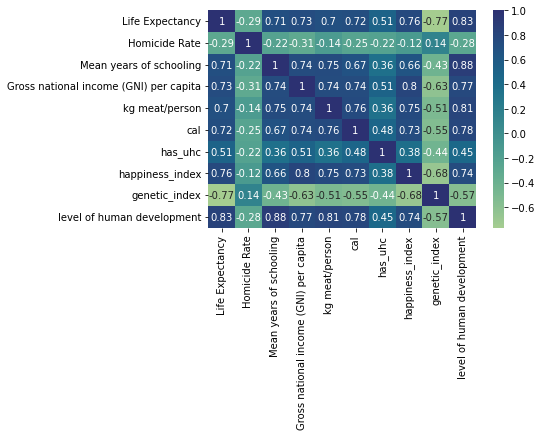

In [42]:
collinearity_matrix = df_final.iloc[:,1:].corr()
sns.heatmap(collinearity_matrix, xticklabels=collinearity_matrix.columns,yticklabels=collinearity_matrix.columns,cmap="crest", annot=True)

## Multivariate Regression Model

In [43]:
def nans(df): return df[df.isnull().any(axis=1)]
nans(df_final)

,Country,Life Expectancy,Homicide Rate,Mean years of schooling,Gross national income (GNI) per capita,kg meat/person,cal,has_uhc,happiness_index,genetic_index,level of human development


In [45]:
data = df_final.iloc[:,2:]
expected = df_final["Life Expectancy"]
model = LinearRegression().fit(data,expected)
predicted = model.predict(data)
residuals = predicted-expected
mse = np.mean((residuals)**2)
slopes = pd.DataFrame(data = model.coef_.reshape(1,9),columns = df_final.iloc[:,2:].columns)
print ("\nMSE:",mse,"\nIntercept:",model.intercept_,"\nSlopes:")
slopes.head()


MSE: 7.8347801511209845 
Intercept: 65.03187207354486 
Slopes:


,Homicide Rate,Mean years of schooling,Gross national income (GNI) per capita,kg meat/person,cal,has_uhc,happiness_index,genetic_index,level of human development
0,-0.064082,0.216492,-0.000046,0.002795,0.000515,1.062475,0.995671,-0.403023,2.611367


## Graphs
- Reisdual error plot

[Text(0.5, 0, 'Predicted Life Expectancy'), Text(0, 0.5, 'Residuals')]

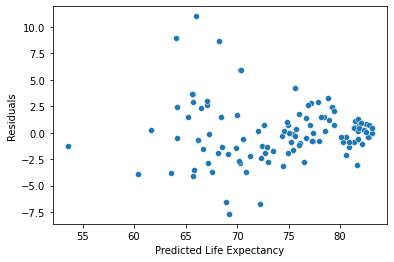

In [46]:
sns.scatterplot(x = predicted, y = residuals).set(xlabel='Predicted Life Expectancy', ylabel='Residuals')

### Summary Statistics

In [47]:
df_final.describe()

,Life Expectancy,Homicide Rate,Mean years of schooling,Gross national income (GNI) per capita,kg meat/person,cal,has_uhc,happiness_index,genetic_index,level of human development
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,74.181112,6.087523,9.538524,22451.396131,49.363211,2957.293578,0.541284,5.671046,17.846789,2.990826
std,6.934363,10.228273,3.063096,19594.529183,29.018068,452.467500,0.500594,1.062122,6.897471,1.084362
min,54.836000,0.260000,2.114962,1198.073924,3.780000,1908.000000,0.000000,3.145000,7.900000,1.000000
25%,70.056000,1.170000,7.192013,6589.980037,20.340000,2662.000000,0.000000,4.934000,11.000000,2.000000
50%,75.387805,2.200000,10.427910,15241.914650,53.490000,3019.000000,1.000000,5.813000,17.800000,3.000000
75%,79.208000,5.370000,12.191084,37931.303590,73.010000,3322.000000,1.000000,6.317000,22.600000,4.000000
max,84.615610,52.020000,14.090967,84649.474670,121.610000,3885.000000,1.000000,7.842000,42.700000,4.000000


### Questions for Reviewers

List specific questions for your peer reviewers
and project mentor to answer in giving you feedback on this phase. <br>
- I had a tough time trying to find graphs to show the analysis, besides correlation matrix and residual plots. What else is a good graph to use for a multivariate analysis?